# Import Libraries


In [19]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import stats

import seaborn as sns
import statsmodels.formula.api as sm
import statsmodels.stats.multicomp as multi

import sklearn
from sklearn import mixture
from sklearn import datasets
from sklearn import model_selection
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Define Functions


In [20]:


colors = ['red', 'orange', 'blue']
#Group is extracted from the dataframe 
def df_groupby_group_extract(df, col_to_extract, group_col, group_to_extract):
    idx = df.index[df[group_col] == group_to_extract]
    column_group = df[col_to_extract][idx]
    return column_group

#Iris csv data is imported as a dataframe
def get_iris_df():
    ds = sklearn.datasets.load_iris()
    df = pd.DataFrame(ds['data'], columns = ds['feature_names'])
    map_code_species = dict(zip(range(3), ds['target_names']))
    df['species'] = [map_code_species[c] for c in ds['target']]
    df.rename(columns={'sepal length (cm)': 'sepal_length',
                       'sepal width (cm)': 'sepal_width', 
                       'petal length (cm)': 'petal_length', 
                       'petal width (cm)': 'petal_width',}, inplace=True)
    return df


#Dataframe mean and variance  
def df_stats(df):
    df_stats = df.agg(['mean', 'var'])      
    return df_stats
#For each specific column determine the dataframe column mean and variance 
def df_stats_wrt_column(df, column):
    df_stats = df.groupby([column]).agg(['mean', 'var'])     # Determine mean & variance of dataframe wrt a specific column
    return df_stats
#Determine the t value
def ttest_1samp_eq(x, u, s, n):
    t = (x - u)/(s/np.sqrt(n))
    return t
#Determine the sample mean vals and sizes
def ttest_1samp(sample, popmean):
    x = sample.mean()
    s = sample.std()
    n = sample.size
    return ttest_1samp_eq(x, popmean, s, n)
#Determine whether or not the dataframe is within the required range
def df_ttest_1samp(df, classes):
    class_names = df[classes].unique()      #Get class names
    column_names = df.columns                  #Determine column names
    num_class = class_names.size               #Get classes count
    ncol = column_names.size - 1               #Useable columns count
    data = np.zeros([num_class, ncol])              #Define zero array
    tstat_df = pd.DataFrame(data, index=class_names, columns=column_names[0:ncol])     #T-stat dataframe is created
    for i in range(num_class):         #Work through classes
        for j in range(ncol):       #Work through columns
            u = df[column_names[j]].mean()                                       #Determine population mean val
            sample = df_groupby_group_extract(df, column_names[j], classes, class_names[i])   # Extract sample
            tstat_df.loc[class_names[i], column_names[j]] = ttest_1samp(sample, u)    
    return tstat_df
#Determine dataframe p value
def df_pval_1samp(df, classes):
    class_names = df[classes].unique()      #Get class names
    column_names = df.columns                  #Determine column names
    num_class = class_names.size         #Get classes count
    ncol = column_names.size - 1               #Useable columns count
    data = np.zeros([num_class, ncol])                                                 #Define zero array
    pval_df = pd.DataFrame(data, index=class_names, columns=column_names[0:ncol])      
    for i in range(num_class):         #Work through classes
        for j in range(ncol):       #Work through columns
            u = df[column_names[j]].mean()            # Population mean
            sample = df_groupby_group_extract(df, column_names[j], classes, class_names[i])    # Extract sample

            pval_df.loc[class_names[i], column_names[j]] = stats.ttest_1samp(sample, u).pvalue  # Determine p value

    return pval_df                                                                                                         
# Add Gaussian Noise 
# Per Class 
def add_noise_per_class(df):
    df_noise = df.copy()                    # Create copy of original dataframe
    class_names = df['species'].unique()    # Get class names
    column_names = df_noise.columns            # Get column names
    num_class = class_names.size         #Get classes count
    ncol = column_names.size - 1               #Useable columns count
    class_std = df_noise.groupby(['species']).std()     # Determine STD of dataframe per class

    for i in range(num_class):         #Work through classes
        for j in range(ncol):       #Work through columns
            std = class_std.at[class_names[i],column_names[j]]                             # Get STD of specific column of a specific class
            idx = df_noise.index[df_noise['species'] == class_names[i]]                 # Determine index of column of a specific class 
            noise = np.random.normal(0, std, size=None)                                 # Determine noise to add 
            df_noise.loc[idx,column_names[j]] = df_noise[column_names[j]][idx] + noise        # Add noise to data

    return df_noise
# Per Element 
def add_noise_per_element(df):
    df_noise = df.copy()                    # Create copy of original dataframe
    class_names = df['species'].unique()    # Get class names
    column_names = df_noise.columns            # Get column names
    num_class = class_names.size               # Determine number of classes
    ncol = column_names.size - 1               # Determine number of usable columns

    class_std = df_noise.groupby(['species']).std()     # Determine STD of dataframe per class

    for i in range(num_class):         #Work through classes
        for j in range(ncol):       #Work through columns
            std = class_std.at[class_names[i],column_names[j]]                     # Get STD of specific column of a specific class
            idx = df_noise.index[df_noise['species'] == class_names[i]]         # Determine index of column of a specific class
            for k in range(idx.size):       # Iterate through elements
                noise = np.random.normal(0, std, size=None)                                     # Determine noise to add
                df_noise.loc[idx[k],column_names[j]] = df_noise[column_names[j]][idx[k]] + noise      # Add noise to data

    return df_noise
# ANOVA Analysis 

def element_anova(df,col_no):
    col_name = df.columns
    d = col_name[col_no] + '~ C(species)'
    subset = sm.ols(formula=d, data=df)
    subset_data = subset.fit().summary()
    subset_data_F = subset_data.tables[0].data[2][3]
    subset_data_P = subset_data.tables[0].data[3][3]
    F = subset_data_F
    P = subset_data_P
    return [F,P]   
# Gausian Clustering    
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')
df = get_iris_df()       
df.rename(columns={'sepal length (cm)': 'sepal_length',
                   'sepal width (cm)': 'sepal_width', 
                   'petal length (cm)': 'petal_length', 
                   'petal width (cm)': 'petal_width',}, inplace=True)

df_stats_original = df_stats(df)                                    # Determine mean and variance of dataframe
species_stats_original_df = df_stats_wrt_column(df,'species')       # Determine mean and variance of dataframe based on species
df_added_noise_class = add_noise_per_class(df)          # Add noise to dataframe per class [same noise added to groups per class]
df_added_noise_element = add_noise_per_element(df)      # Add noise to dataframe per element

df_stats_noise_class = df_stats(df_added_noise_class)           # Determine mean and variance of dataframe [Noise per class] 
df_stats_noise_element = df_stats(df_added_noise_element)  
species_stats_noise_element_df = df_stats_wrt_column(df_added_noise_element,'species')
df_pval = df_pval_1samp(df, 'species')     
pca_org = PCA(n_components=4)                                       # Set number of principal components to retain
original_data = df[df.columns[0:4]]
principalComponents_org = pca_org.fit_transform(original_data)      # Determine principle component values using SVD
principal_org_Df = pd.DataFrame(data = principalComponents_org, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
PCA_org_df = pd.concat([principal_org_Df, df[['species']]], axis = 1)
pca_org_noisy = PCA(n_components=4)                                              # Set number of principal components to retain
original_data_noisy = df_added_noise_element[df_added_noise_element.columns[0:4]]
principalComponents_org_noisy = pca_org_noisy.fit_transform(original_data_noisy)       # Determine principle component values using SVD
principal_org_noisy_df = pd.DataFrame(data = principalComponents_org_noisy, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
PCA_org_noisy_df = pd.concat([principal_org_noisy_df, df_added_noise_element[['species']]], axis = 1)
pca_stand_noisy = PCA(n_components=4)  
zeros_arr = np.zeros([2,4])
GMM_test_org_df = pd.DataFrame(zeros_arr, columns=['spherical', 'diag', 'tied', 'full'],
                                          index=['Train Accuracy', 'Test Accuracy']) 
GMM_test_noisy_df = pd.DataFrame(zeros_arr, columns=['spherical', 'diag', 'tied', 'full'],
                                            index=['Train Accuracy', 'Test Accuracy'])                                          

C:\Users\Willie\AppData\Local\Temp\ipykernel_13532\2709640579.py:23: FutureWarning: ['species'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_stats = df.agg(['mean', 'var'])
C:\Users\Willie\AppData\Local\Temp\ipykernel_13532\2709640579.py:23: FutureWarning: ['species'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_stats = df.agg(['mean', 'var'])
C:\Users\Willie\AppData\Local\Temp\ipykernel_13532\2709640579.py:23: FutureWarning: ['species'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_stats = df.agg(['mean', 'var'])


# Question 1

#1.	K-means clustering: 
a)	Use k-means clustering to determine if the best fit to the data is obtained when assuming that the data consists of either 2, 3 or 4 classes.  Apply k-means clustering to the data to calculate the following results in each case, and summarize the results in a table: 
•	The cluster-based class labels for all observations;
•	The sum of the distances between the observations and their class centres, for each class as well as in total over all classes;
•	The mean of the silhouette values;
•	The accuracy of classification in each case, using the correct class membership.
Generate scatter plots and silhouette plots for each case to illustrate the results.   		(8)
b)	Evaluate the accuracy of classification for the k-means cluster model using 3 clusters, by calculating 
•	how many of the observations in each class are correctly classified into a single cluster;
•	how many observations in total are correctly classified, and what fraction of total observations is correctly classified.
Generate a table with the above results.

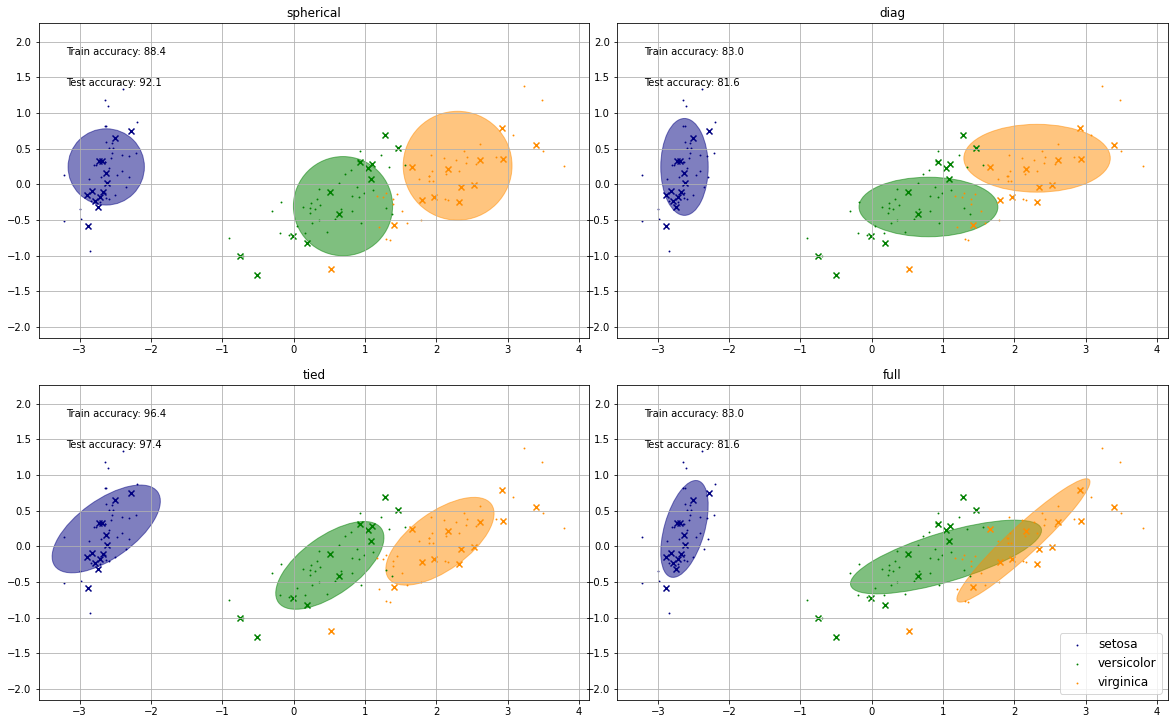

In [21]:
# Original PCA Dataset 
skf = StratifiedKFold(n_splits=4)
data_arr = PCA_org_df[PCA_org_df.columns[0:2]].values
species_arr = pd.factorize(PCA_org_df['species'])[0]
train_index, test_index = next(iter(skf.split(data_arr, species_arr)))
X_train = data_arr[train_index]
y_train = species_arr[train_index]
X_test = data_arr[test_index]
y_test = species_arr[test_index]
n_classes = len(np.unique(y_train))
#With the use of varying covariances we attempt the GMM
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}
zeros_arr = np.zeros([2,4])
GMM_test_org_PCA_df = pd.DataFrame(zeros_arr, columns=['spherical', 'diag', 'tied', 'full'],
                                              index=['Train Accuracy', 'Test Accuracy'])
n_estimators = len(estimators)
colors = ['navy', 'green', 'darkorange']
plt.figure(figsize=(8 * n_estimators // 2, 10))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)
for index, (name, estimator) in enumerate(estimators.items()):
    
    
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0) #GMM is initialized with the use of the training data
                                    for i in range(n_classes)])

    
    estimator.fit(X_train) #Other parameters are trained using EM algorithms
    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = data_arr[species_arr == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=df['species'].unique()[n])
    #Test data is plotted with the use of crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)
        plt.grid()

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)
    GMM_test_org_PCA_df.loc['Train Accuracy', name] = train_accuracy

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)
    GMM_test_org_PCA_df.loc['Test Accuracy', name] = test_accuracy
    plt.title(name)
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
# plt.grid()
plt.show()

C:\Users\Willie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


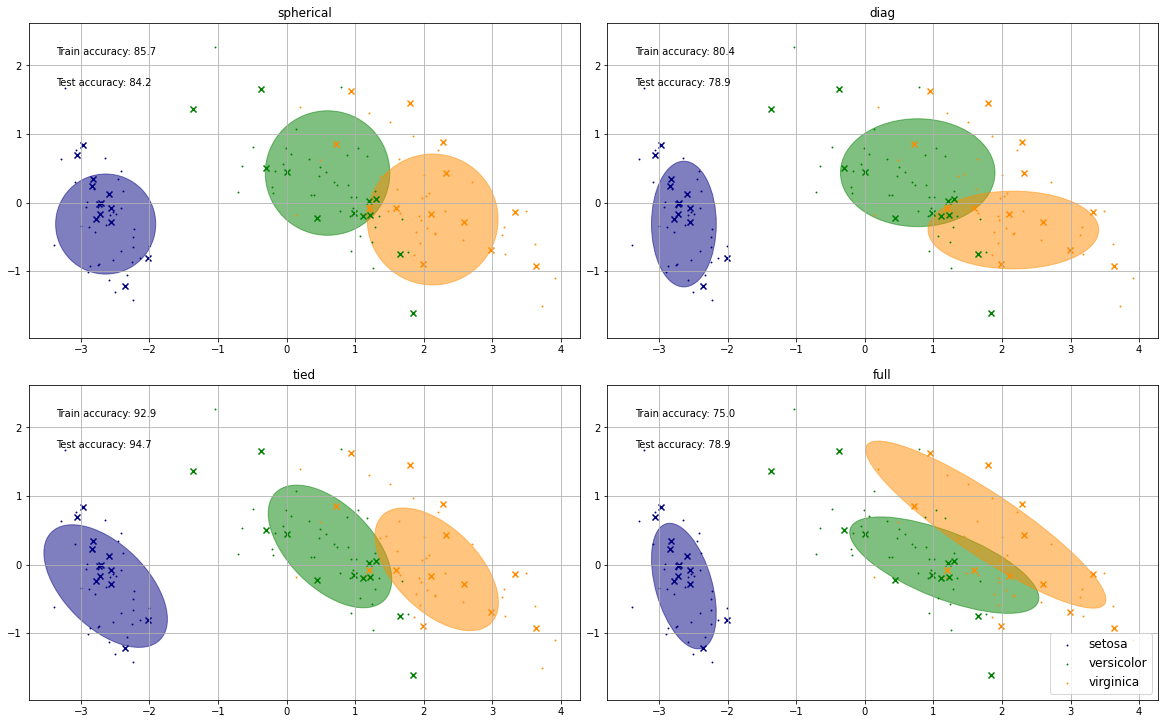

In [22]:

skf = StratifiedKFold(n_splits=4)
data_arr = PCA_org_noisy_df[PCA_org_noisy_df.columns[0:2]].values
species_arr = pd.factorize(PCA_org_noisy_df['species'])[0]
train_index, test_index = next(iter(skf.split(data_arr, species_arr)))
X_train = data_arr[train_index]
y_train = species_arr[train_index]
X_test = data_arr[test_index]
y_test = species_arr[test_index]
n_classes = len(np.unique(y_train))
#With the use of varying covariances we attempt the GMM
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}
zeros_arr = np.zeros([2,4])
GMM_test_noisy_PCA_df = pd.DataFrame(zeros_arr, columns=['spherical', 'diag', 'tied', 'full'],
                                                index=['Train Accuracy', 'Test Accuracy'])
n_estimators = len(estimators)
colors = ['navy', 'green', 'darkorange']
plt.figure(figsize=(8 * n_estimators // 2, 10))
plt.subplots_adjust(bottom=.01, ators // 2, index + 1)
    make_ellipses(estimator, h)
    for n, color in enumerate(colors):
        data = data_arr[species_arr == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=df['species'].unique()[n])
    #Test data is plotted with the use of crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)
        plt.grid()
    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)
    GMM_test_noisy_PCA_df.loc['Train Accuracy', name] = train_accuracy

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)
    GMM_test_noisy_PCA_df.loc['Test Accuracy', name] = test_accuracy
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)
for index, (name, estimator) in enumerate(estimators.items()):
    
    
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0) #GMM is initialized with the use of the training data
                                    for i in range(n_classes)])
    
    estimator.fit(X_train)  #Other parameters are trained using EM algorithms
    h = plt.subplot(2, n_estim

In [23]:
GMM_test_noisy_PCA_df

,spherical,diag,tied,full
Train Accuracy,85.714286,80.357143,92.857143,75.000000
Test Accuracy,84.210526,78.947368,94.736842,78.947368


In [24]:
GMM_test_org_df

,spherical,diag,tied,full
Train Accuracy,0.0,0.0,0.0,0.0
Test Accuracy,0.0,0.0,0.0,0.0


In [25]:
GMM_test_noisy_df

,spherical,diag,tied,full
Train Accuracy,0.0,0.0,0.0,0.0
Test Accuracy,0.0,0.0,0.0,0.0


In [26]:
GMM_test_noisy_PCA_df

,spherical,diag,tied,full
Train Accuracy,85.714286,80.357143,92.857143,75.000000
Test Accuracy,84.210526,78.947368,94.736842,78.947368


In [27]:
GMM_test_org_PCA_df

,spherical,diag,tied,full
Train Accuracy,88.392857,83.035714,96.428571,83.035714
Test Accuracy,92.105263,81.578947,97.368421,81.578947


In [28]:
GMM_test_noisy_PCA_df

,spherical,diag,tied,full
Train Accuracy,85.714286,80.357143,92.857143,75.000000
Test Accuracy,84.210526,78.947368,94.736842,78.947368


# Question 2

#1.	K-means clustering: 
a)	Use k-means clustering to determine if the best fit to the data is obtained when assuming that the data consists of either 2, 3 or 4 classes.  Apply k-means clustering to the data to calculate the following results in each case, and summarize the results in a table: 
•	The cluster-based class labels for all observations;
•	The sum of the distances between the observations and their class centres, for each class as well as in total over all classes;
•	The mean of the silhouette values;
•	The accuracy of classification in each case, using the correct class membership.
Generate scatter plots and silhouette plots for each case to illustrate the results.   		(8)
b)	Evaluate the accuracy of classification for the k-means cluster model using 3 clusters, by calculating 
•	how many of the observations in each class are correctly classified into a single cluster;
•	how many observations in total are correctly classified, and what fraction of total observations is correctly classified.
Generate a table with the above results.


Text(0.5, 1.0, 'Two most prominent features')

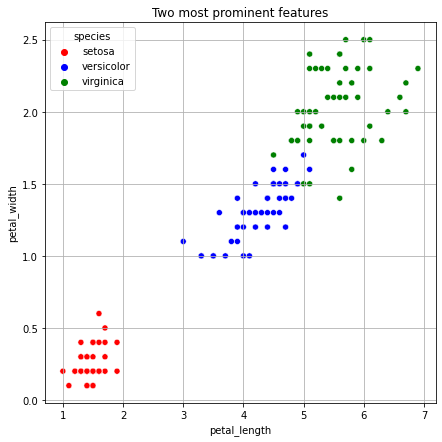

In [29]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=df, 
                x="petal_length",
                y="petal_width", 
                hue="species",
                palette=["red","blue","green"])
plt.grid()
plt.title('Two most prominent features')

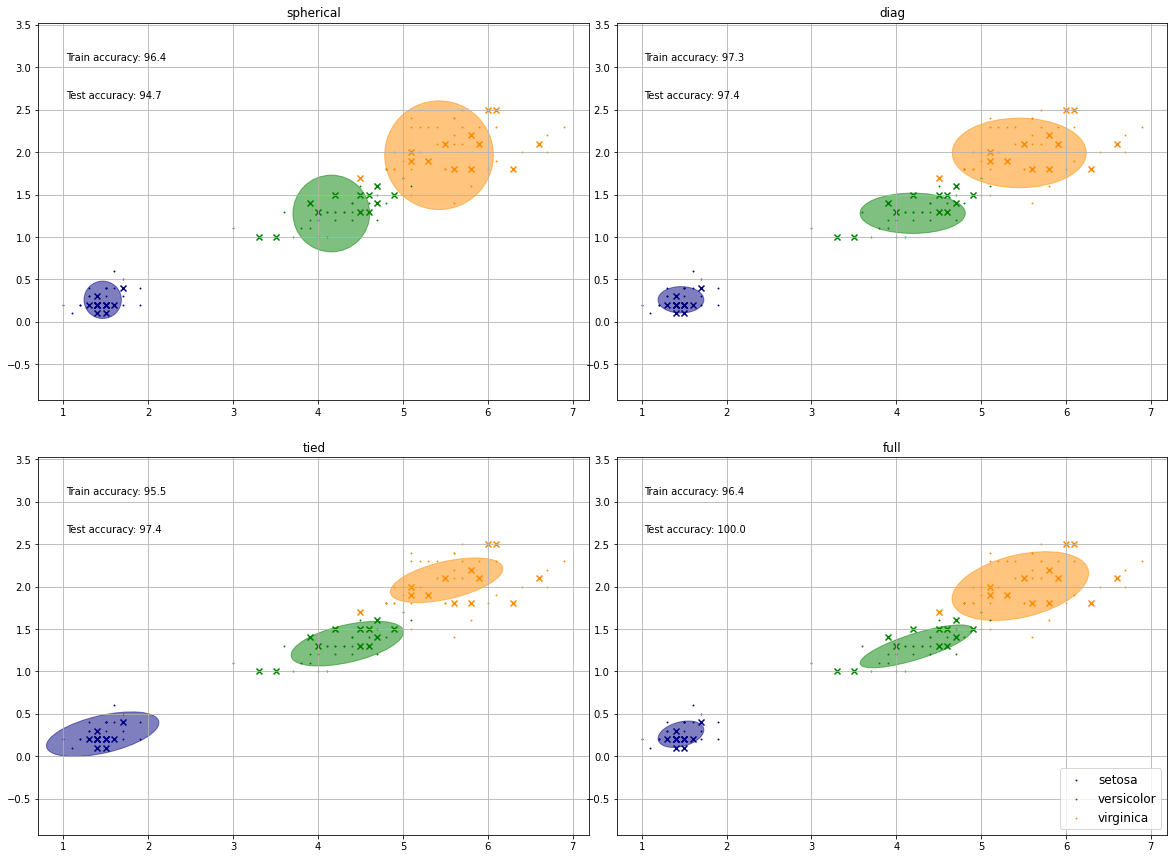

In [30]:
skf = StratifiedKFold(n_splits=4)
data_arr = df[df.columns[2:4]].values
species_arr = pd.factorize(df['species'])[0]
train_index, test_index = next(iter(skf.split(data_arr, species_arr)))
X_train = data_arr[train_index]
y_train = species_arr[train_index]
X_test = data_arr[test_index]
y_test = species_arr[test_index]
n_classes = len(np.unique(y_train))
#With the use of varying covariances we attempt the GMM

estimators = {cov_type: GaussianMixture(n_components=n_classes,  #With the use of varying covariances we attempt the GMM
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}
zeros_arr = np.zeros([2,4])
GMM_test_org_df = pd.DataFrame(zeros_arr, columns=['spherical', 'diag', 'tied', 'full'],
                                          index=['Train Accuracy', 'Test Accuracy'])
n_estimators = len(estimators)
colors = ['navy', 'green', 'darkorange']
plt.figure(figsize=(8 * n_estimators // 2, 12))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)
for index, (name, estimator) in enumerate(estimators.items()):
    
    
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0) #GMM is initialized with the use of the training data
                                    for i in range(n_classes)])
    
    estimator.fit(X_train) #Other parameters are trained using EM algorithms
    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = data_arr[species_arr == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=df['species'].unique()[n])
    #Test data is plotted with the use of crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)
        plt.grid()

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)
    GMM_test_org_df.loc['Train Accuracy', name] = train_accuracy
    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)
    GMM_test_org_df.loc['Test Accuracy', name] = test_accuracy
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()

Display GMM Results for Original Dataset

In [31]:
GMM_test_org_df

,spherical,diag,tied,full
Train Accuracy,96.428571,97.321429,95.535714,96.428571
Test Accuracy,94.736842,97.368421,97.368421,100.000000


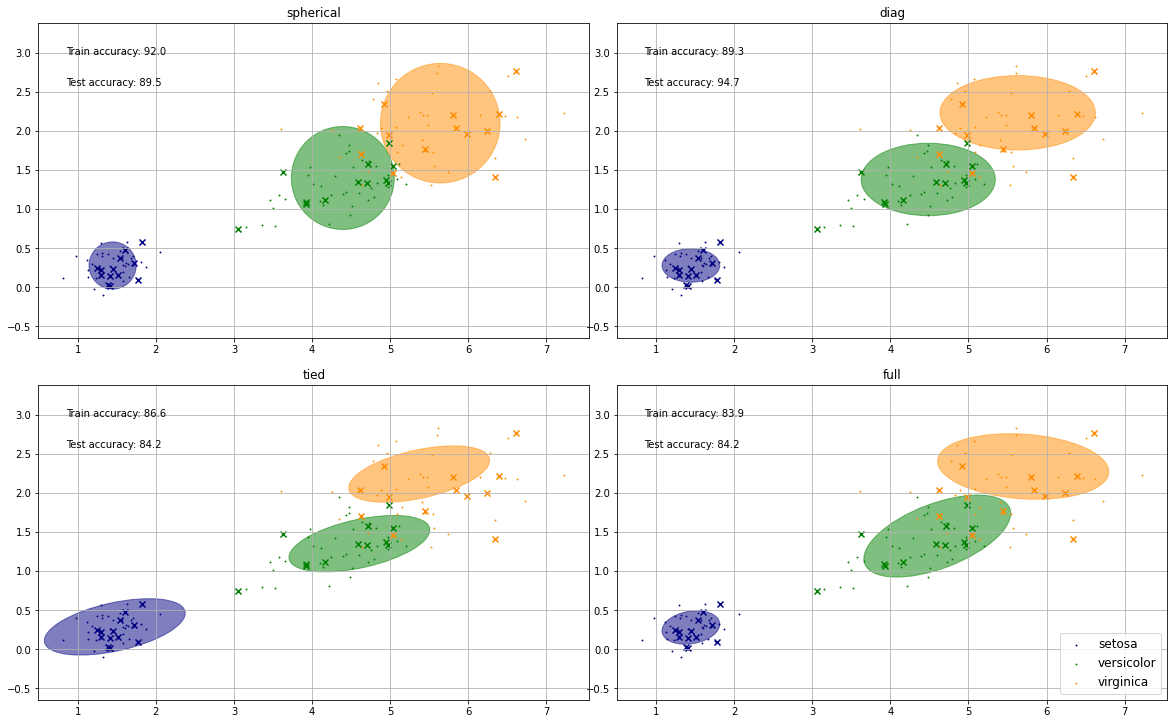

In [32]:

skf = StratifiedKFold(n_splits=4)
data_arr = df_added_noise_element[df_added_noise_element.columns[2:4]].values
species_arr = pd.factorize(df_added_noise_element['species'])[0]
train_index, test_index = next(iter(skf.split(data_arr, species_arr)))
X_train = data_arr[train_index]
y_train = species_arr[train_index]
X_test = data_arr[test_index]
y_test = species_arr[test_index]
n_classes = len(np.unique(y_train))
#With the use of varying covariances we attempt the GMM
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

zeros_arr = np.zeros([2,4])
n_estimators = len(estimators)

colors = ['navy', 'green', 'darkorange']
plt.figure(figsize=(8 * n_estimators // 2, 10))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)
for index, (name, estimator) in enumerate(estimators.items()):
    
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0) #GMM is initialized with the use of the training data
                                    for i in range(n_classes)])

    
    estimator.fit(X_train) #Other parameters are trained using EM algorithms

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = data_arr[species_arr == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=df['species'].unique()[n])
    #Test data is plotted with the use of crosses
    for n, color in enumerate(colors): 
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)
        plt.grid()

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)
    GMM_test_noisy_df.loc['Train Accuracy', name] = train_accuracy

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)
    GMM_test_noisy_df.loc['Test Accuracy', name] = test_accuracy
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()


Display GMM Results for Noisy Dataset

In [33]:
GMM_test_noisy_df

,spherical,diag,tied,full
Train Accuracy,91.964286,89.285714,86.607143,83.928571
Test Accuracy,89.473684,94.736842,84.210526,84.210526


Displaying Original GMM Results again fro comparissons...

In [34]:
GMM_test_org_df

,spherical,diag,tied,full
Train Accuracy,96.428571,97.321429,95.535714,96.428571
Test Accuracy,94.736842,97.368421,97.368421,100.000000
